In [1]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Load the MNIST dataset

In [2]:
from sklearn.datasets import fetch_openml
import numpy as np

In [3]:
mnist = fetch_openml("mnist_784", version=1)

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist["data"], mnist["target"]
# X is a pd.DataFrame, but we need a numpy array
X = X.to_numpy()
y = y.to_numpy().astype(np.uint8)

In [6]:
print(type(X))
print(type(y))
print(X.shape)
print(y.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(70000, 784)
(70000,)


In [7]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [8]:
import numpy as np

sample = np.random.randint(0, X.shape[0] - 1)
some_digit = X[sample]
some_digit_reshape = some_digit.reshape(
    tuple(
        [np.sqrt(X.shape[1]).astype("int")]*2
    )
)


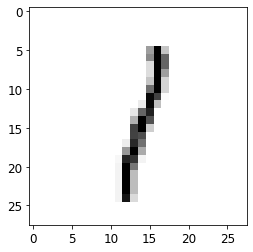

In [9]:
plt.imshow(some_digit_reshape, cmap="binary")

In [10]:
y[sample]

1

## Split train and test sets

In [11]:
train_test_ratio = 0.8
limit = round(X.shape[0]*train_test_ratio)
# the dataset is already shuffled
X_train, X_test, y_train, y_test = X[:limit], X[limit:], y[:limit], y[limit:]

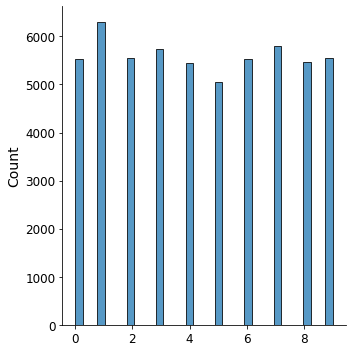

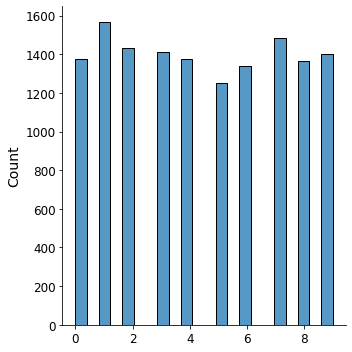

In [12]:
# TODO: some data exploration to check categories are correctly shuffled
import seaborn as sns

sns.displot(y_train)
sns.displot(y_test)

# Binary classifier

In [14]:
# transform target vector
y_train_5 = y_train == 5
y_test_5 = y_test == 5

## Stocastic gradient descent classifier (sklearn)

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [16]:
# cross validation from scratch
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

In [17]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    print(f"train_index: {train_index}")
    print(f"test_index: {test_index}")
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(f"fold accuracy: {n_correct / len(y_pred)}")

train_index: [18623 18624 18625 ... 55997 55998 55999]
test_index: [    0     1     2 ... 19108 19130 19160]
fold accuracy: 0.9595542936733272
train_index: [    0     1     2 ... 55997 55998 55999]
test_index: [18623 18624 18625 ... 37453 37465 37472]
fold accuracy: 0.9608399850002679
train_index: [    0     1     2 ... 37453 37465 37472]
test_index: [37319 37320 37321 ... 55997 55998 55999]
fold accuracy: 0.9566591663988


In [18]:
# sklearn built-in function for cross validation
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95955429, 0.96083999, 0.95665917])

In [19]:
# create a dummy classifies

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y): 
        pass
    def predict(self, X): 
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never5classifier = Never5Classifier()

cross_val_score(never5classifier, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91193014, 0.90812664, 0.90887175])

In [21]:
np.mean(y == 5)

0.09018571428571429

## Confusion Matrix

In [22]:
from sklearn.model_selection import cross_val_predict
# cross_val_predict is similat to cross_val_score, but it returns 
# predicted values in each test fold

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
# lets create first confusion matrix by hand

positives_index = np.flatnonzero(y_train_pred)
negatives_index = np.flatnonzero(~y_train_pred)
TP = sum(y_train_5[positives_index])
FP = len(positives_index) - TP
TN = sum(~y_train_5[negatives_index])
FN = len(negatives_index) - TN

In [24]:
conf_matrix = np.array([[TN, FP], [FN, TP]])

In [25]:
# with sklearn 
from sklearn.metrics import confusion_matrix
bi_conf_matrix = confusion_matrix(y_train_5, y_train_pred)

In [26]:
print(conf_matrix)
print(bi_conf_matrix)

[[50190   750]
 [ 1545  3515]]
[[50190   750]
 [ 1545  3515]]


In [27]:
# let us compute precision and recall by hand and with sklearn built-in functions
from sklearn.metrics import precision_score, recall_score
precision = TP / (TP + FP)
bi_precision = precision_score(y_train_5, y_train_pred)
recall = TP / (TP + FN)
bi_recall = recall_score(y_train_5, y_train_pred)

In [28]:
print(f"Hand made precision: {precision:0.2f}")
print(f"Built in precision: {bi_precision:0.2f}")
print(f"Hand made recall: {recall:0.2f}")
print(f"Built in recall: {bi_recall:0.2f}")

Hand made precision: 0.82
Built in precision: 0.82
Hand made recall: 0.69
Built in recall: 0.69


In [29]:
# now f1 score
from sklearn.metrics import f1_score
f1 = 2 / (1/precision + 1/recall)
bi_f1 = f1_score(y_train_5, y_train_pred)
print(f"Hand made F1 score: {f1:0.2f}")
print(f"Built in F1 score: {bi_f1:0.2f}")

Hand made F1 score: 0.75
Built in F1 score: 0.75


## The precision/recall trade off

In sklearn, classifiers have a method called `decision_function` that gives us the score a certain instance has. We classify our inputs depending of this score being higher than a certain therhold. For example, the `SGDClassifier` uses a threshold equal to 0. 

In [30]:
y_train_scores = sgd_clf.decision_function(X_train)

In [31]:
y_train_scores

array([  1433.16522916,  -8029.51613618, -11209.96183223, ...,
       -14131.40661703,  -1915.28465727,   -942.63545019])

In [32]:
threshold = 0
y_train_pred_2 = (y_train_scores > threshold)

In [33]:
y_train_pred = sgd_clf.predict(X_train)

In [34]:
all(y_train_pred == y_train_pred_2)

True

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [36]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, point_precision=None):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    if (point_precision):
        point_recall = recalls[np.argmax(precisions >= point_precision)]
        point_threshold = thresholds[np.argmax(precisions >= point_precision)]
        plt.plot([point_threshold, point_threshold], [0., point_precision], "r:")                 
        plt.plot([-50000, point_threshold], [point_precision, point_precision], "r:")                                
        plt.plot([-50000, point_threshold], [point_recall, point_recall], "r:")
        plt.plot([point_threshold], [point_precision], "ro")                                             
        plt.plot([point_threshold], [point_recall], "ro")
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1]) 
    plt.title("Precision/Recall curve")            

Saving figure precision_recall_curve


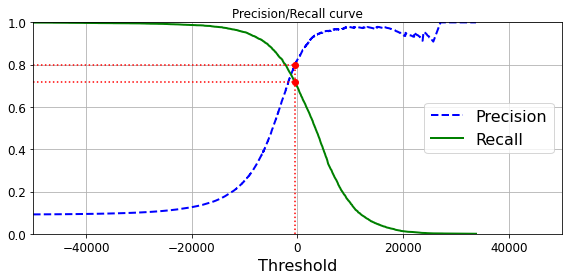

In [38]:
plt.figure(figsize=(8, 4))    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, point_precision=0.8)                            
save_fig("precision_recall_curve")
plt.show()

In [39]:
def plot_precision_vs_recall(precisions, recalls, point_precision=None):
    plt.plot(precisions, recalls, "b--", linewidth=2)
    if (point_precision):
        point_index = np.argmin(np.abs(precisions - 0.8))
        point_precision = precisions[point_index]
        point_recall = recalls[point_index]
        plt.plot([point_precision, point_precision], [0, point_recall], "r:", linewidth=2)
        plt.plot([0, point_precision], [point_recall, point_recall], "r:", linewidth=2)
        plt.plot([point_precision], [point_recall], "ro")
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.grid(True)
    plt.title("Precision vs Recall")

Saving figure precision_recall


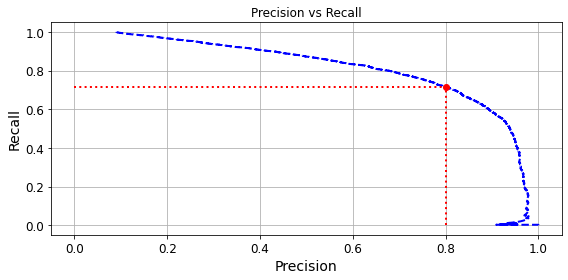

In [40]:
plt.figure(figsize=(8,4))
plot_precision_vs_recall(precisions, recalls, 0.8)
save_fig("precision_recall")
plt.show()

## ROC curve
Another common tool when using binary classifiers is the so called **ROC curve** *(receiver operating characteristic)* which plots TPR vs FPR. 
- TPR (true positive rate): also called sensitivity or recall, is the ratio of real positives that have been correctly classified
$$
TPR = \frac{TP}{TP + FN}
$$
- FPR (false positive rate): is the ratio of real negatives that has been incorrectly classified as positives
$$
FPR = \frac{FP}{FP + TN} = 1 - \frac{TN}{FP + TN} = 1 - \textit{specificity}
$$

In [46]:
from sklearn.metrics import roc_curve
fpr, tpr, thersholds = roc_curve(y_train_5, y_scores)

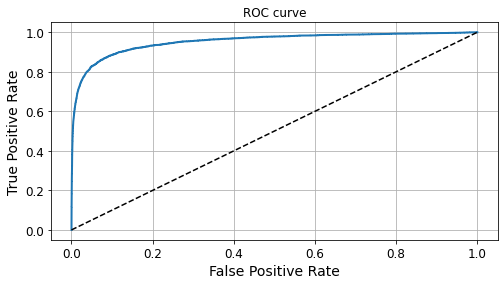

In [49]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()
    plt.title("ROC curve")

plt.figure(figsize=(8,4))
plot_roc_curve(fpr, tpr)
plt.show()

### AUC score
One way to evaluate classifiers is to look a the AUC (area under the curve). The higher the area, the best a classifier will performe. Sklearn provides a function to compute the ROC AUC, `roc_auc_score`

In [71]:
from sklearn.metrics import roc_auc_score
sgd_auc = roc_auc_score(y_train_5, y_scores)
print(sgd_auc)

0.9530898127068813


## ROC Curve vs PR Curve
The key point when evaluating a classifier is to decide which is more important, false positives or false negatives. For example,
- Predict cancer on patients: minimize false negatives.
- Detect safe videos for children: minimize false positives.
> You should use PR Curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve and de AUC score. 

In the detect 5 digits problem, looking at the AUC we could conclude there is no room for improvement (because there are few 5s (positives)), but the PR curve makes it clear we can do better. 

Now let us train another classifier (in this case a random forest classifier) and compare its ROC curve with the Stocastic Gradient Descend Classifier. 

`RandomForestClassifier` does not have a `decision_function` method like `SGDClassifier`. Instead, it has a `predict_proba` method. Sklearn classifiers generally have one or the other, or both. The `predict_proba` method returns an array containing a row per instance and a column per class, each containing the probability that the fiven instance belongs to the given class. 

In [72]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [73]:
y_scores_forest = y_probas_forest[:, 1] # probability of positive class
fpr_forest, tpr_forest, thersholds_forest = roc_curve(y_train_5, y_scores_forest)
precision_forest, recall_forest, thersholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

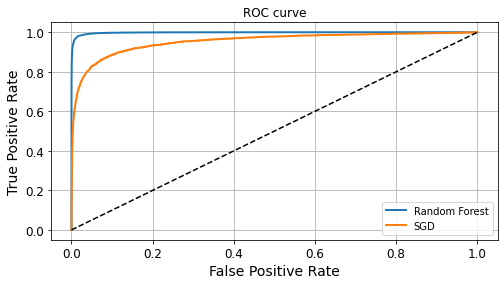

In [74]:
plt.figure(figsize=(8, 4))
plt.plot(fpr_forest, tpr_forest, linewidth=2, label="Random Forest")
plot_roc_curve(fpr, tpr, label="SGD")
plt.legend()
plt.show()

In [75]:
forest_auc = roc_auc_score(y_train_5, y_scores_forest)

In [76]:
# precision/recall of Random Forest Classifier
y_pred_forest = y_probas_forest[:, 1] > 0.5
forest_precision = precision_score(y_train_5, y_pred_forest)
forest_recall = recall_score(y_train_5, y_pred_forest)
sgd_precision = precision
sgd_recall = recall

In [87]:
import pandas as pd

metrics_data = {
    "Forest": [forest_auc, forest_precision, forest_recall], 
    "SGD": [sgd_auc, sgd_precision, sgd_recall]
}

df_summary = pd.DataFrame(
    metrics_data, index=["auc", "precision", "recall"]
)

In [88]:
# format pandas table

def make_pretty(styler):
    styler.set_caption("Metric comparison between classfiers")
    styler.background_gradient(axis=None, vmin=0, vmax=1, cmap="YlGnBu")
    return styler

In [89]:
df_summary.style.pipe(make_pretty)

,Forest,SGD
auc,0.998275,0.953090
precision,0.989647,0.824150
recall,0.868972,0.694664


## Multiclass clasification